In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import json
import fastai
import math
from functools import partial
import os

In [2]:
ROOT = "../../data/protein/structure/secondary_structure/"
DATA_PATH = ROOT+"cullpdb"
MODEL_PATH = "../../weights/protein/structure/secondary_structure/cullpdb"
SEQUENCE_LENGTH=512
VOCAB_SIZE=20
BERT_CONFIG_FILE = "../../../bert/config/bert_config_file.json"
BERT_WEIGHTS = "../../../bert_pytorch/weights/tpu"
NUM_CLASSES = 9

In [3]:
epochs = 3
num_workers = 8 # On cloud 8
batch_size = 64

In [4]:

class EnzymeDataSet(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, path, seq_length, is_test=True, vocab_size=20, random=False):
        self.data = np.load(os.path.join(path, "data.npy"))
        self.mutations = np.load(os.path.join(path, "mutations_cumsum.npy"))
        self.lengths = np.load(os.path.join(path, "lengths.npy"))
        self.seq_length = seq_length
        self.is_test = is_test
        self.vocab_size = vocab_size
        self.random = random
        self.vocab_size = np.arange(1, vocab_size+1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data[idx]
        seq = row[0][0:512]
        label =  row[1][0:512]
        mutations = self.mutations[idx]
        length = min(512,self.lengths[idx])
        
        if not self.is_test:
            mutation_size = int(length*0.2)
            indicies = np.sort(np.random.randint(1,length-1, mutation_size))
            selected = mutations[indicies]
            random_mutation = np.random.rand(len(selected), 1)
            mutated_amino_acids = (random_mutation < selected).argmax(axis=1) + 1
            np.put(seq, indicies, mutated_amino_acids)
            
        mask = np.ones(length)
        mask = np.pad(mask, mode="constant", pad_width=(0,len(seq)-length))
        return (np.int64(seq) , mask), label

In [5]:
train_ds = EnzymeDataSet(os.path.join(DATA_PATH, "train"), SEQUENCE_LENGTH, is_test=False, vocab_size=VOCAB_SIZE)
val_ds = EnzymeDataSet(os.path.join(DATA_PATH, "val"), SEQUENCE_LENGTH)
test_ds = EnzymeDataSet(os.path.join(DATA_PATH, "test"), SEQUENCE_LENGTH)

In [6]:
train_ds.__getitem__(80)

((array([11, 15, 18,  6, ...,  0,  0,  0,  0]),
  array([1., 1., 1., 1., ..., 0., 0., 0., 0.])),
 array([2, 3, 3, 3, ..., 0, 0, 0, 0]))

In [60]:
from modeling import *
class BertEnzymeClassification(nn.Module):
    def __init__(self, config, num_labels):
        super(BertEnzymeClassification, self).__init__()
        self.bert = BertModel(config)
        self.conv1 = nn.Conv1d(config.hidden_size, config.hidden_size, 5)
        self.padding = nn.ReflectionPad1d((2,2))
        self.bn = nn.BatchNorm1d(config.hidden_size)
        self.conv2 = nn.Conv1d(config.hidden_size, num_labels, 1)
        self.bert_layer = BERTLayer(config)

        def init_weights(module):
            if isinstance(module, (nn.Conv1d)):
                # Slightly different from the TF version which uses truncated_normal for initialization
                # cf https://github.com/pytorch/pytorch/pull/5617
                module.weight.data.normal_(mean=0.0, std=config.initializer_range)
            elif isinstance(module, BERTLayerNorm):
                module.beta.data.normal_(mean=0.0, std=config.initializer_range)
                module.gamma.data.normal_(mean=0.0, std=config.initializer_range)
        self.apply(init_weights)

    def forward(self, input_ids, attention_mask, labels=None):
        all_encoder_layers, pooled_output = self.bert(input_ids, attention_mask=attention_mask)
        last_encoder_layer = all_encoder_layers[-1]
        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
        last_encoder_layer = self.bert_layer(last_encoder_layer, attention_mask=extended_attention_mask.float())
        print(last_encoder_layer[0][:][0])
        last_encoder_layer = self.padding(last_encoder_layer)
        output = self.conv1(last_encoder_layer)
        output = torch.nn.functional.relu(self.bn(output))
        output = self.conv2(output)
        return output

In [61]:
from modeling import BertConfig
bert_config = BertConfig.from_json_file(BERT_CONFIG_FILE)

In [62]:
enzymeClassifier = BertEnzymeClassification(bert_config, NUM_CLASSES)
enzymeClassifier.bert.load_state_dict(torch.load(BERT_WEIGHTS, map_location='cpu'))
enzymeClassifier.to('cuda')

BertEnzymeClassification(
  (bert): BertModel(
    (embeddings): BERTEmbeddings(
      (word_embeddings): Embedding(22, 512)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(16, 512)
      (LayerNorm): BERTLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BERTEncoder(
      (layer): ModuleList(
        (0): BERTLayer(
          (attention): BERTAttention(
            (self): BERTSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BERTSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): BERTLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediate): BERTIntermediate(


In [63]:
enzymeClassifier.bert.embeddings.word_embeddings.weight[0][0]

tensor(-0.01, device='cuda:0', grad_fn=<SelectBackward>)

In [64]:
for n, p in enzymeClassifier.bert.named_parameters():
    if p.requires_grad: 
        p.requires_grad=False

In [65]:
from optimization import BERTAdam
param_optimizer = list(enzymeClassifier.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if n not in no_decay], 'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if n in no_decay], 'weight_decay_rate': 0.0}
    ]
train_examples = len(np.load(DATA_PATH+"/train/data.npy"))
num_train_steps = int(train_examples / batch_size / epochs)
optimizer = partial(BERTAdam, params = optimizer_grouped_parameters,
                     lr=5e-5,
                     warmup=0.1,
                     t_total=num_train_steps)

In [66]:
[p.shape for p in enzymeClassifier.parameters() if p.requires_grad]

[torch.Size([512, 512, 5]),
 torch.Size([512]),
 torch.Size([512]),
 torch.Size([512]),
 torch.Size([9, 512, 1]),
 torch.Size([9]),
 torch.Size([512, 512]),
 torch.Size([512]),
 torch.Size([512, 512]),
 torch.Size([512]),
 torch.Size([512, 512]),
 torch.Size([512]),
 torch.Size([512, 512]),
 torch.Size([512]),
 torch.Size([512]),
 torch.Size([512]),
 torch.Size([2048, 512]),
 torch.Size([2048]),
 torch.Size([512, 2048]),
 torch.Size([512]),
 torch.Size([512]),
 torch.Size([512])]

In [67]:
sum(p.numel() for p in enzymeClassifier.parameters() if p.requires_grad)

4469257

In [68]:
criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.01, 3.290247, 1.77455 , 1.57773 , 3.032445, 1.      , 3.39651 , 2.58894 , 2.397312]).cuda())

In [69]:
def accuracy(input, targs):
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    mask = (targs > 0)
    targs = targs.masked_select(mask)
    input = input.argmax(dim=1)
    input = input.masked_select(mask)
    return (input==targs).float().mean()

In [70]:
data = fastai.basic_data.DataBunch.create(train_ds=train_ds, valid_ds=val_ds, test_ds=test_ds, bs=batch_size, num_workers=num_workers)
learner = fastai.basic_train.Learner(data, enzymeClassifier, 
        loss_func=criterion, 
        metrics=accuracy, 
        #opt_func=optimizer,
        path=None, 
        model_dir='models')

In [71]:
learner.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy


tensor([ 2.06e-02,  1.45e-03, -1.66e-02,  6.41e-03, -6.14e-03,  5.87e-02,
        -2.53e-03, -7.33e-03,  6.58e-02, -1.81e-02,  3.44e-03,  2.67e-02,
         8.11e-03, -4.53e-03,  6.11e-02,  6.56e-03,  1.18e-02,  4.02e-02,
         1.17e-03,  2.44e-02,  1.56e-02,  2.89e-02,  1.31e-02,  2.49e-03,
         3.78e-02,  1.93e-02, -2.53e-02,  4.90e-03, -1.03e-02, -7.42e-02,
         5.65e-02, -4.66e-02,  7.00e-03, -4.36e-02,  1.82e-02,  8.37e-03,
         1.76e-02,  4.78e-02,  2.72e-02, -2.08e-02,  1.63e-02,  3.32e-02,
         4.78e-03,  3.65e-02,  1.44e-03,  2.79e-02,  1.88e-02,  1.26e-02,
         3.73e-03, -3.19e-04,  1.30e-02, -3.81e-03, -4.18e-02,  4.07e-02,
        -4.75e-04,  9.84e-04, -2.04e-03,  8.63e-03, -7.96e-03, -2.81e-02,
        -2.75e-03, -3.11e-03,  3.52e-02,  2.55e-03,  2.64e-03, -1.15e-02,
         3.91e-03, -2.12e-02, -1.17e-02,  5.08e-03,  3.44e-03,  3.23e-02,
        -4.74e-03, -2.51e-02, -3.25e-02, -3.33e-02,  1.11e-02, -2.89e-02,
         8.61e-03, -4.18e-02, -1.36e-0

tensor([ 5.25e-02,  4.87e-04, -6.97e-03,  2.36e-02, -1.85e-02,  5.17e-02,
         3.22e-02,  1.51e-03,  6.31e-02, -1.48e-02,  7.49e-03,  2.69e-02,
         6.34e-03,  1.02e-02,  6.78e-02,  1.11e-02,  5.65e-04,  4.07e-02,
         4.16e-02,  2.05e-02, -1.09e-02,  3.13e-02,  1.43e-02,  1.19e-02,
         3.59e-02,  3.73e-02, -3.16e-02, -1.08e-03,  8.17e-04, -7.01e-02,
         5.47e-02, -3.01e-02,  7.61e-03, -4.13e-02,  7.63e-03,  7.41e-03,
         1.36e-02,  3.31e-02,  4.18e-02, -1.71e-02,  1.66e-02, -6.90e-03,
        -5.72e-03,  3.54e-02,  1.10e-02,  2.45e-02,  1.82e-02,  1.23e-02,
         5.09e-03, -5.28e-03,  4.43e-03,  4.95e-03, -2.28e-02,  1.89e-02,
        -5.45e-03, -4.74e-03, -1.21e-02,  8.35e-03,  1.63e-03, -2.37e-02,
         2.02e-04, -4.76e-03,  4.16e-02,  7.38e-03,  1.00e-02, -1.70e-02,
         3.48e-03, -1.93e-02, -1.18e-02,  1.13e-02,  1.11e-02,  2.44e-02,
        -2.53e-03, -5.83e-03, -2.50e-02, -3.10e-02,  7.47e-03, -2.65e-02,
        -2.86e-03, -3.79e-02, -2.97e-0

tensor([ 6.94e-02,  4.47e-03,  1.87e-02,  1.75e-02,  1.21e-02,  6.13e-02,
         4.89e-02, -7.91e-03,  6.34e-02, -1.26e-02,  1.04e-02,  2.69e-02,
         1.84e-02,  1.70e-02,  3.10e-02,  1.23e-02,  1.61e-02,  3.93e-02,
         2.85e-02,  2.73e-02,  1.42e-03,  3.43e-02,  1.68e-02, -1.61e-02,
         3.83e-02,  3.49e-02, -1.67e-02,  1.26e-02,  1.87e-02, -6.21e-02,
         4.68e-02, -2.13e-02,  1.22e-02, -3.92e-02,  3.56e-03,  8.02e-03,
         1.68e-02,  4.40e-02,  4.75e-02, -5.29e-03,  1.72e-02,  2.96e-03,
         1.15e-02,  3.45e-02,  1.56e-02,  1.77e-02,  1.77e-02,  1.29e-02,
         3.88e-03, -1.03e-02,  6.31e-03,  5.46e-03, -1.25e-02,  1.29e-02,
         1.25e-02,  6.05e-03, -1.31e-02,  8.82e-03,  1.11e-02, -1.83e-02,
         2.54e-03, -9.69e-03,  3.62e-02, -1.20e-04,  1.02e-02, -6.98e-03,
         5.71e-03, -2.63e-02, -1.13e-02,  1.09e-02, -3.28e-02,  2.27e-02,
        -3.86e-03, -3.41e-03, -1.74e-02, -2.85e-02,  3.66e-03, -2.38e-02,
        -1.33e-03, -3.77e-02, -5.70e-0

tensor([ 7.92e-02,  8.74e-03,  2.22e-02,  3.00e-02,  2.77e-02,  6.27e-02,
         6.57e-02,  1.83e-02,  6.53e-02, -1.10e-02,  1.34e-02,  2.72e-02,
         1.18e-02,  1.76e-02,  5.93e-02,  1.46e-02,  1.07e-02,  4.04e-02,
         2.65e-02,  3.44e-02,  1.56e-02,  3.61e-02,  2.14e-02,  2.37e-02,
         4.13e-02,  3.70e-02,  1.22e-02,  4.17e-03,  1.04e-02, -6.55e-02,
         3.67e-02, -7.96e-03,  1.98e-02, -3.62e-02, -1.74e-04,  9.27e-03,
         1.78e-02,  7.37e-02,  3.30e-02,  6.36e-03,  1.75e-02,  5.55e-02,
         2.12e-02,  3.56e-02,  1.30e-02,  3.17e-02,  1.79e-02,  1.32e-02,
         9.73e-03, -4.68e-03,  2.31e-02, -2.40e-03, -1.20e-02,  3.76e-02,
         4.81e-03,  9.85e-03, -4.35e-03,  9.10e-03,  8.99e-03, -1.89e-02,
         4.89e-03, -1.25e-02,  2.74e-02,  6.43e-03,  1.73e-02,  5.43e-03,
         6.62e-03, -1.50e-02, -1.09e-02,  1.27e-02, -3.87e-03,  2.59e-02,
        -1.14e-03,  6.48e-03, -6.93e-03, -2.70e-02, -4.85e-03, -2.49e-02,
         8.04e-03, -4.33e-02,  4.20e-0

tensor([ 9.58e-02,  1.21e-02,  4.03e-02,  3.04e-02,  2.08e-02,  7.05e-02,
         3.17e-02, -1.30e-02,  6.05e-02, -1.26e-02,  2.07e-02,  2.75e-02,
         1.73e-02,  2.69e-02,  5.62e-02,  6.66e-03,  4.59e-03,  4.06e-02,
         5.16e-02,  3.92e-02,  1.94e-02,  3.84e-02,  2.28e-02, -1.16e-02,
         4.48e-02,  4.07e-02,  4.57e-03,  2.57e-02,  3.35e-02, -3.24e-02,
         5.12e-02,  8.03e-03,  1.86e-02, -2.72e-02,  2.97e-02,  1.09e-02,
         1.85e-02,  6.74e-02,  5.16e-02,  1.33e-02,  1.78e-02,  2.11e-02,
         2.47e-02,  3.62e-02,  1.69e-02,  3.10e-02,  1.85e-02,  1.34e-02,
         7.50e-03,  3.60e-03,  2.12e-02,  1.45e-02,  1.17e-02,  3.77e-02,
         3.45e-03,  1.30e-02, -6.90e-03,  9.65e-03,  2.25e-02, -2.70e-03,
         4.32e-03, -2.40e-04,  3.54e-02,  2.10e-03,  3.07e-02,  6.30e-03,
         5.55e-03, -5.66e-03, -1.06e-02,  1.08e-02,  8.62e-03,  3.84e-02,
         1.88e-04,  2.48e-02,  3.32e-05, -2.47e-02,  9.92e-03, -2.29e-02,
         1.83e-02, -3.16e-02,  5.52e-0

tensor([ 0.11,  0.01,  0.04,  0.01,  0.03,  0.06,  0.04,  0.03,  0.07, -0.01,
         0.02,  0.03,  0.02,  0.03,  0.08,  0.02,  0.01,  0.04,  0.05,  0.04,
         0.02,  0.03,  0.03,  0.02,  0.04,  0.04,  0.01,  0.02,  0.04, -0.03,
         0.06,  0.02,  0.03, -0.03,  0.01,  0.01,  0.02,  0.05,  0.06,  0.02,
         0.02,  0.03,  0.03,  0.04,  0.03,  0.04,  0.02,  0.01,  0.01,  0.00,
         0.03,  0.02,  0.02,  0.06,  0.01,  0.02, -0.01,  0.01,  0.02, -0.01,
         0.01,  0.00,  0.04,  0.01,  0.03,  0.01,  0.01, -0.00, -0.01,  0.01,
         0.02,  0.03,  0.00,  0.03,  0.01, -0.02,  0.01, -0.02,  0.02, -0.03,
        -0.00,  0.02,  0.02,  0.03,  0.02,  0.05,  0.01,  0.04,  0.01,  0.03,
         0.06,  0.03,  0.04,  0.01,  0.02,  0.04,  0.04, -0.02,  0.04,  0.02,
         0.02,  0.08,  0.04,  0.01,  0.02,  0.01,  0.02,  0.02,  0.02,  0.04,
         0.00,  0.09, -0.01,  0.00,  0.01, -0.01,  0.04, -0.00,  0.03,  0.03,
         0.02,  0.03,  0.01,  0.01,  0.02,  0.04,  0.00,  0.02, 

tensor([ 1.08e-01,  1.36e-02,  3.13e-02,  2.08e-02,  2.15e-02,  4.54e-02,
         5.37e-02,  1.97e-02,  6.45e-02, -7.04e-03,  1.72e-02,  2.79e-02,
         1.21e-02,  2.47e-02,  4.68e-02,  1.54e-02,  8.74e-03,  4.09e-02,
         2.98e-02,  3.28e-02,  2.34e-02,  3.57e-02,  1.81e-02,  1.97e-02,
         3.49e-02,  4.53e-02, -9.06e-03, -1.17e-04,  3.16e-02, -2.65e-02,
         5.89e-02,  2.69e-02,  3.20e-02, -1.86e-02,  2.15e-02,  1.34e-02,
         1.83e-02,  5.60e-02,  5.07e-02,  1.40e-02,  1.82e-02,  2.50e-02,
         3.00e-02,  3.53e-02,  7.62e-03,  3.79e-02,  1.96e-02,  1.38e-02,
         1.52e-02,  7.69e-03,  2.94e-02,  2.06e-02, -8.74e-03,  5.94e-02,
         6.81e-03,  2.36e-02, -4.41e-04,  1.27e-02, -2.00e-02,  6.47e-03,
         9.86e-03,  3.93e-03,  4.33e-02,  1.25e-02,  2.99e-02,  1.37e-02,
         1.45e-02,  1.00e-02, -9.77e-03,  1.62e-02,  2.49e-02,  4.54e-02,
         5.43e-03,  3.76e-02,  1.46e-02, -1.73e-02,  2.24e-02, -1.75e-02,
         3.36e-02, -3.44e-02, -2.58e-0

tensor([ 1.07e-01,  1.23e-02,  1.74e-02,  1.33e-02,  2.23e-02,  4.23e-02,
         3.63e-02,  2.74e-02,  6.25e-02, -6.24e-03,  1.94e-02,  2.82e-02,
         1.65e-02,  7.69e-03,  2.10e-02,  1.46e-02,  4.45e-04,  4.06e-02,
         2.76e-02,  2.88e-02,  1.58e-02,  3.18e-02,  1.80e-02, -1.61e-02,
         3.79e-02,  4.47e-02,  1.69e-02,  1.57e-02,  3.75e-02, -4.86e-02,
         5.96e-02, -6.76e-03,  3.73e-02, -1.56e-02,  2.63e-02,  1.40e-02,
         2.04e-02,  3.76e-02,  4.46e-02,  1.08e-02,  1.80e-02,  2.06e-02,
         3.14e-02,  3.56e-02,  3.33e-02,  1.84e-02,  1.95e-02,  1.42e-02,
         1.67e-02,  1.21e-02,  3.25e-02,  1.90e-02,  3.63e-02,  1.83e-02,
         1.61e-03,  2.52e-02,  4.46e-04,  1.22e-02,  4.02e-02,  1.06e-03,
         9.50e-03,  1.44e-03,  4.35e-02,  9.79e-03,  2.46e-02,  3.34e-02,
         1.65e-02,  1.48e-02, -9.30e-03,  1.93e-02,  3.73e-02,  4.95e-02,
         5.72e-03,  4.71e-02,  2.03e-02, -2.98e-02,  2.42e-02, -1.56e-02,
         3.58e-03, -3.03e-02,  1.81e-0

tensor([ 0.12,  0.01,  0.02, -0.01,  0.01,  0.03,  0.03,  0.03,  0.06, -0.01,
         0.02,  0.03,  0.01,  0.03,  0.04,  0.01,  0.00,  0.04,  0.02,  0.03,
         0.02,  0.03,  0.01,  0.01,  0.03,  0.03,  0.02,  0.01,  0.03, -0.01,
         0.06,  0.04,  0.04, -0.03,  0.04,  0.02,  0.02,  0.04,  0.04,  0.02,
         0.02, -0.01,  0.03,  0.03,  0.03,  0.02,  0.02,  0.01,  0.01,  0.00,
         0.03,  0.02,  0.03,  0.05,  0.00,  0.03,  0.01,  0.01,  0.05,  0.01,
         0.01,  0.01,  0.05,  0.01,  0.02,  0.04,  0.02, -0.00, -0.01,  0.02,
         0.03,  0.05,  0.01,  0.01,  0.02, -0.03,  0.03, -0.02,  0.00, -0.03,
        -0.00,  0.03,  0.02,  0.03,  0.00,  0.04,  0.01,  0.02,  0.01,  0.02,
         0.05,  0.02,  0.03,  0.02,  0.03,  0.04,  0.05, -0.02,  0.05,  0.03,
        -0.00,  0.05,  0.04,  0.02,  0.02,  0.01,  0.03,  0.02,  0.01,  0.03,
         0.00,  0.05, -0.00,  0.01,  0.02, -0.00,  0.02,  0.01,  0.03,  0.03,
         0.01,  0.03,  0.01,  0.00,  0.02,  0.03,  0.00,  0.02, 

tensor([ 0.12,  0.00,  0.01,  0.01, -0.00,  0.02,  0.03,  0.02,  0.06, -0.01,
         0.01,  0.03,  0.01,  0.03,  0.01,  0.01, -0.00,  0.04,  0.02,  0.03,
         0.01,  0.03,  0.01,  0.00,  0.03,  0.03, -0.01,  0.01,  0.03, -0.01,
         0.05,  0.04,  0.04, -0.01,  0.03,  0.01,  0.02,  0.03,  0.04,  0.01,
         0.02,  0.01,  0.03,  0.03,  0.02,  0.03,  0.02,  0.02,  0.02,  0.01,
         0.04,  0.02, -0.01,  0.03,  0.01,  0.03,  0.02,  0.02,  0.05,  0.02,
         0.01,  0.01,  0.04,  0.01,  0.03,  0.03,  0.02, -0.00, -0.01,  0.02,
         0.03,  0.04,  0.01,  0.01,  0.03, -0.03,  0.04, -0.01,  0.05, -0.02,
         0.00,  0.06,  0.01,  0.02,  0.01,  0.04,  0.01,  0.02,  0.01,  0.02,
         0.04,  0.02,  0.02,  0.02,  0.03,  0.03,  0.03, -0.02,  0.04,  0.03,
         0.00,  0.04,  0.03,  0.02,  0.03,  0.01,  0.04,  0.02,  0.01,  0.04,
         0.00,  0.08, -0.00,  0.01, -0.00, -0.00,  0.06, -0.00,  0.03,  0.03,
         0.01,  0.03,  0.01,  0.00,  0.02,  0.04,  0.01,  0.02, 

tensor([ 2.05e-02,  8.90e-04,  1.53e-04, -5.05e-04,  1.55e-02,  2.53e-02,
         2.31e-02,  2.14e-02,  5.58e-02, -6.66e-03,  1.10e-02,  2.91e-02,
         7.63e-03,  2.66e-02,  1.75e-02,  1.36e-02, -2.89e-03,  4.02e-02,
         1.19e-02,  2.36e-02,  1.61e-02,  2.44e-02,  5.01e-03, -1.29e-03,
         2.87e-02,  3.13e-02,  1.73e-02,  7.75e-03,  3.38e-02, -3.46e-02,
         5.58e-02,  3.57e-02,  3.39e-02, -9.59e-03,  3.28e-02,  1.64e-02,
         1.94e-02,  2.67e-02,  3.86e-02,  1.10e-02,  1.79e-02,  8.60e-03,
         2.63e-02,  3.04e-02,  1.88e-02,  2.71e-02,  1.95e-02,  1.56e-02,
         2.15e-02,  1.27e-02,  3.71e-02,  1.65e-02,  3.04e-02,  3.17e-02,
         7.67e-03,  2.84e-02,  4.16e-03,  1.44e-02,  5.08e-02, -8.12e-03,
         1.68e-02,  1.59e-02,  4.40e-02,  5.96e-03,  2.97e-02,  3.99e-02,
         2.00e-02,  2.34e-02, -7.72e-03,  1.64e-02,  4.33e-02,  3.91e-02,
         3.19e-03,  4.04e-02,  2.88e-02, -2.78e-02,  4.29e-02, -5.97e-03,
         5.52e-02, -2.63e-02,  2.16e-0

Traceback (most recent call last):
  File "/home/donatas_repecka/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/donatas_repecka/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
Traceback (most recent call last):
  File "/home/donatas_repecka/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/donatas_repecka/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/donatas_repecka/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
Traceback (most recent call last):
  File "/home/donatas_repecka/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/donatas_repecka/anaconda3/lib/python3.6/multiprocessing/connection

KeyboardInterrupt: 

In [ ]:
learner.fit(2)

In [31]:
preds, truth =learner.get_preds(is_test=True)

In [32]:
accuracy(preds, truth)

tensor(0.4369)

In [33]:
acc = []
min_element = 0
min_score = 1
s = [0, 0, 0, 0, 0, 0, 0, 0, 0]
s_g = [0, 0, 0, 0, 0, 0, 0, 0, 0]
s_t = [0, 0, 0, 0, 0, 0, 0, 0, 0]
s_f = [0, 0, 0, 0, 0, 0, 0, 0, 0]
for row in range(len(truth)):

    a = preds.argmax(dim=1)[row]
    correct = 0
    actual = 0
    for i, t in enumerate(truth[row]):
        s[t] = s[t]+1
        if t != 0: # and t != 1:
            s_g[a[i]] = s_g[a[i]] + 1
            actual += 1
            if a[i] == t:        
                correct += 1
                s_t[t] = s_t[t]+1
            else:
                s_f[a[i]] = s_f[a[i]]+1 
    score = correct/actual
    if min_score > score:
        min_score = score
        min_element = row
    acc.append(score)

print(np.mean(acc))

0.46915959464697954


In [34]:
w = np.asarray(s[1:9])
t = np.power(1-(w/w.sum()),3)
t/min(t)

array([3.6514  , 2.037437, 1.829964, 3.333135, 1.      , 3.774721, 2.948575, 2.648912])

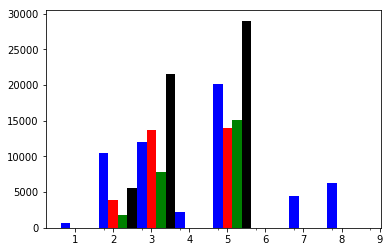

In [35]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

ind = np.arange(len(s[1:9]))+1
width = 0.25
ax.bar(ind-width, s[1:9], width, color='b')
ax.bar(ind , s_f[1:9], width, color='r')
ax.bar(ind + width, s_t[1:9], width, color='g')
ax.bar(ind + width+ width, s_g[1:9], width, color='black')
ax.set_xticks(ind + width+ width+width, len(s) + width / 2)
plt.show()

In [36]:
s, s_g, s_t, s_f, np.asarray(s_t)/np.asarray(s), np.asarray(s_f)/np.asarray(s)

/home/donatas_repecka/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


([83138, 618, 10428, 12035, 2280, 20079, 0, 4436, 6250],
 [20, 0, 5600, 21489, 0, 29005, 0, 0, 12],
 [0, 0, 1733, 7759, 0, 15030, 0, 0, 1],
 [20, 0, 3867, 13730, 0, 13975, 0, 0, 11],
 array([0.000000e+00, 0.000000e+00, 1.661872e-01, 6.447029e-01, 0.000000e+00, 7.485433e-01,          nan, 0.000000e+00,
        1.600000e-04]),
 array([2.405639e-04, 0.000000e+00, 3.708285e-01, 1.140839e+00, 0.000000e+00, 6.960008e-01,          nan, 0.000000e+00,
        1.760000e-03]))

In [59]:
torch.set_printoptions(precision=2)
preds[i][:,11], preds.argmax(dim=1)[i][11], truth[i][11]

(tensor([2.41e-04, 3.61e-02, 2.27e-01, 2.61e-01, 7.22e-02, 5.07e-02, 6.71e-04,
         1.52e-01, 2.00e-01]), tensor(3), tensor(7))

In [39]:
i = min_element
print(acc[i])
preds.argmax(dim=1)[i], truth[i]

0.09090909090909091


(tensor([2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0

In [38]:
preds.argmax(dim=1)[0], preds.argmax(dim=1)[89]

(tensor([2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 0, 0,
         0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0